In [1]:
import numpy as np
import rasterio
import rasterio.mask
from rasterio.windows import Window
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.model_selection import train_test_split
import torch
import matplotlib as mpl
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os
from rasterio.merge import merge

In [19]:
def transform_crs(dst_crs, resolution):

    input_paths = []
    output_paths = []

    # biomass data
    for year in [2010,2015]:
        input_paths.append(f"../data/raw/biomass/amazonia/{resolution}m/" + f"mapbiomas-brazil-collection-70-amazonia-{year}.tif")
        output_paths.append(f"../data/processed/{resolution}m/landuse/" + f"biomass_{year}.tif")

    for input_path, output_path in zip(input_paths, output_paths):
        with rasterio.open(input_path) as src:
            transform, width, height = calculate_default_transform(
                src.crs, dst_crs, src.width, src.height, *src.bounds)
            kwargs = src.meta.copy()
            kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height
            })
            with rasterio.open(output_path, 'w', **kwargs, compress="DEFLATE") as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest)

In [3]:
transform_crs("EPSG:6933", 30)

In [7]:
# function to transform labels to 0=forest, 1=natural, 2=farming, 3=urban, 4=water, 255=unknown
def transform_biodata_to_labels(bio_data):
    class_dict = {1:0, 3:0, 4:0, 5:0,49:0, # forest
                10:1,11:1,12:1,32:1,29:1,13:1, 13:1, 50:1, # natural
                14:2,15:2,18:2,19:2,39:2,20:2,40:2,61:2,41:2,36:2,46:2,47:2,48:2,9:2,21:2, # farming
                22:3,23:3,24:3,30:3,25:3, # urban
                26:4,33:4,31:4, # water
                27:255,0:255} # unobserved
    bio_data_new = np.zeros_like(bio_data).astype(np.uint8)
    for key, value in class_dict.items():
        bio_data_new[bio_data == key] = value
    return bio_data_new

In [8]:
# function to load biomass data
def load_biomass_data(year=None,resolution=30):
    path_bio = f"../data/processed/{resolution}m/landuse/" + f"biomass_{year}.tif"
    with rasterio.open(path_bio) as src:
        out_meta = src.meta
        bio_data = src.read(1)
    return bio_data, out_meta

In [9]:
 # preprocess bio data
for year in [2010,2015]:
    bio_data, out_meta = load_biomass_data(year)
    bio_data = transform_biodata_to_labels(bio_data)
    with rasterio.open(f"../data/processed/{30}m/landuse/" + f"biomass_{year}.tif", "w", **out_meta, compress="DEFLATE") as dest:
        dest.write(np.expand_dims(bio_data, axis=0))

In [2]:
# function to load biomass data
def merge_mosaic(year=None, resolution=30, dst_crs="EPSG:6933"):
    
    path_bio = f"../data/raw/biomass/amazonia/{resolution}m/deforestation/" 
    path_bios = [path_bio + name for name in os.listdir(path_bio) if f"-{year}-" in name]
    
    src_files_to_mosaic = []
    for fp in path_bios:
        src = rasterio.open(fp)
        src_files_to_mosaic.append(src)

    mosaic, out_trans = merge(src_files_to_mosaic)
    mosaic = (mosaic/100).astype(np.uint8)
    
    out_meta = src.meta.copy()
    
    # Get bounds of the merged mosaic
    out_height, out_width = mosaic.shape[1], mosaic.shape[2]
    out_ulx, out_uly = out_trans * (0, 0)
    out_lrx, out_lry = out_trans * (out_width, out_height)
    bounds = (out_ulx, out_lry, out_lrx, out_uly)

    out_meta.update({"driver": "GTiff", 
                     "height": mosaic.shape[1],
                     "width": mosaic.shape[2],
                     "transform": out_trans
                     })
    
    transform, width, height = calculate_default_transform(
            src.crs, dst_crs, out_meta['width'], out_meta['height'], *bounds)
    
    out_meta.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height
    })
    
    path_out = f"../data/processed/{30}m/deforestation/"  + f"deforestation_{year}.tif"
    with rasterio.open(path_out, "w", **out_meta, compress="DEFLATE") as dest:
        reproject(
            source=mosaic[0],
            destination=rasterio.band(dest, 1),
            src_transform=out_trans,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest)

In [3]:
for year in range(1995, 2019):
    merge_mosaic(year)

# Create dataset

In [2]:
import rasterio
from rasterio.windows import Window

path = f"../data/processed/{30}m/deforestation/"  + f"deforestation_{2011}.tif"
# Open the mosaic file
with rasterio.open(path) as src:
    # Define the window
    x, y, input_px = 50000, 50000, 35
    window = Window(x - int(input_px/2), y - int(input_px/2), input_px, input_px)

    # Read the data from the window, ensure that it is filled with nodata
    data = src.read(window=window, boundless=True, fill_value=0)
    # data = src.read()
    data = data.squeeze()


In [3]:
data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [37]:
# only keep every nth pixel
delta = 50
data = data[::delta,::delta]

In [38]:
data.shape

(1911, 2038)

In [39]:
# create dataset with columns x, y, value
# reshape data to 1D array
data_points = data.reshape(-1)
# get x and y coordinates
x = np.arange(0, data.shape[1]) * n
y = np.arange(0, data.shape[0]) * n
xv, yv = np.meshgrid(x, y)
# create array with x, y, value
data_points = np.vstack((xv.flatten(), yv.flatten(), data_points)).T


In [40]:
# filter datapoints to only keep values that are 2 or 4
data_points = data_points[(data_points[:,2] == 2) | (data_points[:,2] == 4)]

In [41]:
np.count_nonzero(data_points[:,-1] == 4)/data_points.shape[0]

0.0015760868226828446

In [43]:
# split datapoints into train and validation set
train_data, val_data = train_test_split(data_points, test_size=0.2, random_state=42, stratify=data_points[:,-1])

# downsample train data to have 20% labels 4
train_data_deforested = train_data[train_data[:,-1] == 4]
train_data_not_deforested = train_data[train_data[:,-1] == 2]
train_data_not_deforested = train_data_not_deforested[np.random.choice(train_data_not_deforested.shape[0], train_data_deforested.shape[0] * 4, replace=False)]
train_data = np.vstack((train_data_deforested, train_data_not_deforested))

In [44]:
print(train_data.shape)
print(val_data.shape)

(10240, 3)
(324856, 3)


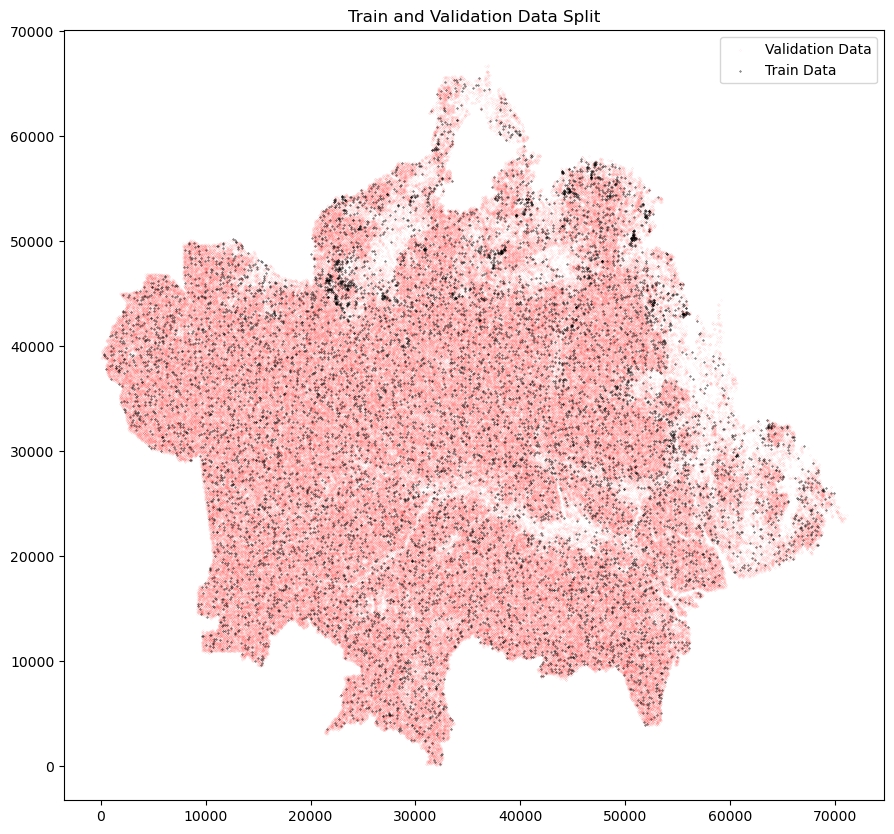

In [60]:
# plot layers
fig, axs = plt.subplots(figsize=(15,10))
axs.scatter(val_data[:,0], val_data[:,1], s=0.001, c='red', alpha=1)
axs.scatter(train_data[:,0], train_data[:,1], s=0.1, c='k', alpha=1)
axs.set_aspect('equal', 'box')
axs.set_title('Train and Validation Data Split')
# add legend, validation data is red, train data is black
axs.legend(['Validation Data', 'Train Data'])
# plt.savefig('reports/figures/data_split/train_val_data_split.png')
plt.show()

# Plots

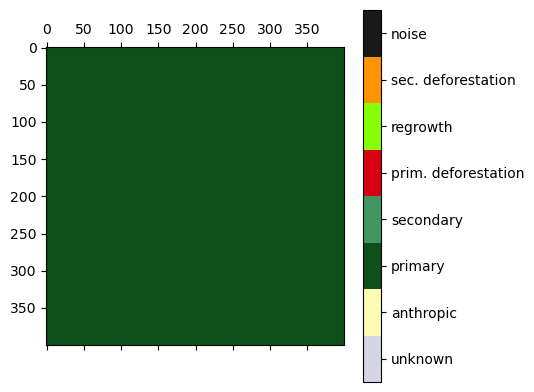

In [5]:
cmap = colors.ListedColormap(['#D5D5E5', '#FFFCB5','#0F5018', '#409562', '#D90016', '#87FF0A', '#FD9407', '#191919'])
mat = plt.matshow(data,cmap=cmap,vmin = -.5, vmax = 7.5)
cax = plt.colorbar(mat, ticks=np.arange(0,8))
cax.ax.set_yticklabels(['unknown', 'anthropic', 'primary', 'secondary', 'prim. deforestation', 'regrowth', 'sec. deforestation', 'noise'])
plt.show()

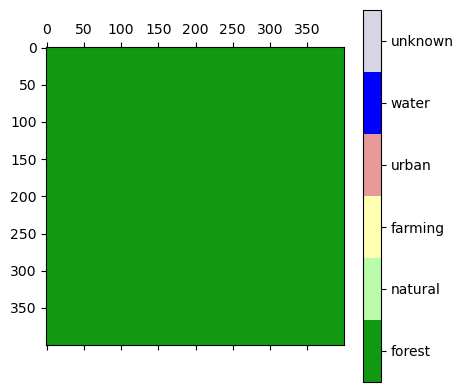

In [13]:
cmap = colors.ListedColormap(['#129912','#bbfcac', '#ffffb2', '#ea9999', '#0000ff', '#D5D5E5'])
mat = plt.matshow(data,cmap=cmap,vmin = -.5, vmax = 5.5)
cax = plt.colorbar(mat, ticks=np.arange(0,6))
cax.ax.set_yticklabels(['forest', 'natural', 'farming', 'urban', 'water', 'unknown'])
plt.show()

In [21]:
# area_amazonia = 4196943 * 100 # reported online
area_amazonia = 421544315 # calculated with ESG
observed_px = np.count_nonzero(data != 0)
adapted_px_dim = np.sqrt(area_amazonia * 10000 / observed_px)
np.count_nonzero(data == 4) * adapted_px_dim**2 / 10000 # reported: 740159.18 ha (2019) vs 740822

740822.7306206718